# GRS-34806 MGI Project
## Download the data
This template downloads the UCM data (both mono and multi-labels) in your local Colab environment. 


In [1]:
# install required modules
!pip install Keras-Applications

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [2]:
# import required modules
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import warnings
from zipfile import ZipFile
from keras.callbacks import TensorBoard
from time import time

from skimage.io import imread, imsave
from fastai.vision import *
from fastai.callbacks import CSVLogger, SaveModelCallback
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tensorflow.keras.applications.vgg16 import VGG16
import torchvision.models as models
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

In [3]:
# import required data
! git clone https://git.wur.nl/lobry001/ucmdata.git
os.chdir('ucmdata')

with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('UCMImages')

!mv UCMImages/UCMerced_LandUse/Images .
!rm -rf UCMImages README.md  UCMerced_LandUse.zip
!ls

UCM_images_path = "Images/"
Multilabels_path = "LandUse_Multilabeled.txt"
source_dir = os.path.join('/content', 'ucmdata', 'Images/')


Cloning into 'ucmdata'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8
Unpacking objects: 100% (8/8), done.
Images	LandUse_Multilabeled.txt


In [4]:
# Set random seed for reproducibility
np.random.seed(8)

In [5]:
# create image directory hierarchy: Train, test and Validate folders

# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory
flow_base = os.path.join('/content', 'flow')

# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./content/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)
          
            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)

                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)

                filenames = filenames[count:]

               

    # Show future warnings during development
    warnings.resetwarnings()

In [6]:
# calculate means for all channels in images in training folder
# these can be used to normalize the image values before training
means = []
for root, _, filenames in os.walk(target_dirs['train']):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        image = imread(filepath)
        means.append(np.mean(image, axis=(0, 1)))
channel_means = np.mean(means, axis=0)

In [8]:
# Get bottleneck_features X and Labels Y for the input dataset (train/test/validate)

def get_bottleneck_features(model, dataset, preproc_func, batch_size=64):
    """
    by predicting on the convolutional portion only of a pretrained model.
       
    Inputs:
        model: Pre-trained deep learning model, excluding fully-connected top model
               e.g. applications.VGG16(include_top=False, weights='imagenet')
        dataset = string label for dataset image directory ['train', 'validate', 'test']
        preproc_func: preprocessing function implied to each input sample
        batch_size: number of image samples per batch
    
    Return:
        Return bottleneck features as numpy.array
    """
    print(f'Generating "{dataset}" bottleneck predictions')
    X_filepath = os.path.join('/content/flow', 'bn_' + dataset + '_X.npy')
    y_filepath = os.path.join('/content/flow', 'bn_' + dataset + '_y.npy')

    # Check if data are available from disk.
    try:
        with open(X_filepath, 'rb') as f:
            X = np.load(f)
        with open(y_filepath, 'rb') as f:
            y = np.load(f)
            Y = to_categorical(y, num_classes=len(np.unique(y)))
    # Else, get the bottleneck features and labels
    except:
        image_data_gen = ImageDataGenerator(rescale=1/224.0, preprocessing_function=preproc_func)
        image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                             batch_size=batch_size,
                                                             shuffle=False)
        image_count = 0
        X_batches, Y_batches = [], []
        for X, Y in image_generator:
            X_batches.append(model.predict_on_batch(X))
            Y_batches.append(Y)
            image_count += X.shape[0]
            # Must interrupt image_generator
            if image_count >= image_generator.n:
                break

        X = np.concatenate(X_batches)
        with open(X_filepath, 'wb') as f:
            np.save(f, X) 
        Y = np.concatenate(Y_batches)
        y = np.nonzero(Y)[1]
        with open(y_filepath, 'wb') as f:
            np.save(f, y)
    
    print(f'   Features of shape {X.shape} extracted for model "{model.name}"')
    return X, Y


# Single-Label classification
In this section, we are performing the single-label classification. 

In [226]:
# insert settings for model

# dropout
dropout = 0

# learning rate
lr = 0.0001

# batch_size
bs = 64

# number of epochs
epochs = 100

In [227]:
# Load all the required pre trained models
#cnn = VGG16(include_top=False, weights='imagenet')
cnn = ResNet152V2(include_top=False, weights='imagenet')

In [228]:
# extract bottleneck features from pretrained model
# change input model in line 8 and choose between vgg_model or resnet_model
num_classes = len(class_names)
X, Y = dict(), dict()
preprocess = lambda x: x - channel_means
for dataset in ['train', 'validate', 'test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(cnn, dataset, preprocess)

Generating "train" bottleneck predictions
   Features of shape (1680, 8, 8, 512) extracted for model "resnet152v2"
Generating "validate" bottleneck predictions
   Features of shape (210, 8, 8, 512) extracted for model "resnet152v2"
Generating "test" bottleneck predictions
   Features of shape (210, 8, 8, 512) extracted for model "resnet152v2"


In [229]:
# build a classifier model to put on top of the convolutional model
def build_fully_connected(model, input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [230]:
model = build_fully_connected(cnn, input_shape=X['train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['train'], Y['train'], batch_size=bs, epochs=epochs,
                              verbose=2, validation_data=(X['validate'], Y['validate']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
27/27 - 1s - loss: 1.7053 - accuracy: 0.5381 - val_loss: 0.8677 - val_accuracy: 0.7762
Epoch 2/100
27/27 - 0s - loss: 0.4221 - accuracy: 0.9179 - val_loss: 0.5490 - val_accuracy: 0.8143
Epoch 3/100
27/27 - 0s - loss: 0.1959 - accuracy: 0.9708 - val_loss: 0.4322 - val_accuracy: 0.8810
Epoch 4/100
27/27 - 0s - loss: 0.1063 - accuracy: 0.9905 - val_loss: 0.3902 - val_accuracy: 0.8714
Epoch 5/100
27/27 - 0s - loss: 0.0665 - accuracy: 0.9982 - val_loss: 0.3351 - val_accuracy: 0.9000
Epoch 6/100
27/27 - 0s - loss: 0.0475 - accuracy: 0.9982 - val_loss: 0.3141 - val_accuracy: 0.9048
Epoch 7/100
27/27 - 0s - loss: 0.0360 - accuracy: 0.9994 - val_loss: 0.3075 - val_accuracy: 0.9048
Epoch 8/100
27/27 - 0s - loss: 0.0282 - accuracy: 0.9994 - val_loss: 0.3011 - val_accuracy: 0.9000
Epoch 9/100
27/27 - 0s - loss: 0.0230 - accuracy: 0.9994 - val_loss: 0.3015 - val_accuracy: 0.9000
Epoch 10/100
27/27 - 0s - loss: 0.0199 - accuracy: 0.9994 - val_loss: 0.2885 - val_accuracy: 0.9143
Epoch 11/

In [231]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

# Merge training and validation data
X_train = np.concatenate([X['train'], X['validate']])
Y_train = np.concatenate([Y['train'], Y['validate']])

# Randomly shuffle X and Y
shuffle_index = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index]
Y_train = Y_train[shuffle_index]
model = build_fully_connected(cnn, input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X_train, Y_train, batch_size=bs, epochs=epochs, verbose=0)

Stop training at 72 epochs


In [232]:
# Flatten Y into a vector
y_test = np.nonzero(Y['test'])[1]

# Predict on the test images
y_pred = model.predict_classes(X['test'], verbose=0)

accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model predication accuracy: 0.905

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       0.90      0.90      0.90        10
           3       0.83      1.00      0.91        10
           4       0.78      0.70      0.74        10
           5       1.00      1.00      1.00        10
           6       1.00      0.40      0.57        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       0.91      1.00      0.95        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       0.71      1.00      0.83        10
          13       0.80      0.80      0.80        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.0

# Multi-Label classification
In this section, we are performing the multi-label classification. 

In [237]:
# insert settings for model
# dropout
dropout = 0

# learning rate
lr = 0.0001

# batch_size
bs = 64

# number of epochs
epochs = 100

# image size
size = 224

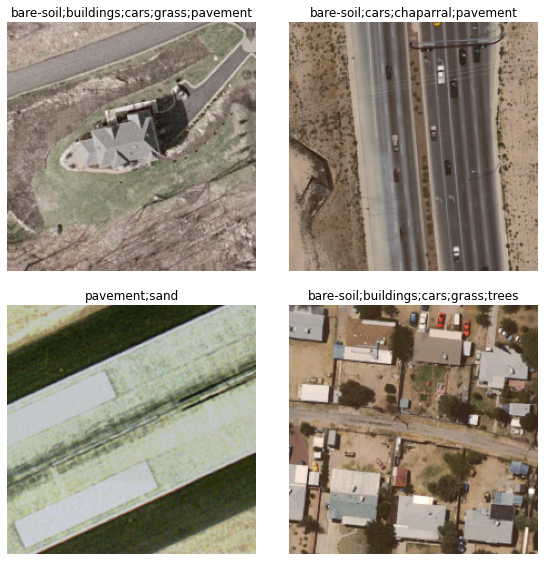

In [238]:
# load Landuse_Multilabeled classes
df = pd.read_csv("/content/ucmdata/LandUse_Multilabeled.txt", sep="\t")
df.head()

# Create Class count dataframe
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)

# loop through Images subfolder and place all .tif files in Images folder
# this is a required step for adding the multilabels to images
for root, dirs, files in os.walk(os.path.abspath("/content/ucmdata/Images")):
    for file in files:
        shutil.move(os.path.join(root, file), os.path.join("/content/ucmdata/Images", file))

# fastai function that merges multilabels with images
data_src = (ImageList.from_df(df=df, path="/content/ucmdata", folder = 'Images', suffix=".tif")
        .split_subsets(train_size=0.8, valid_size=0.2)
        .label_from_df(list(class_count['class']),  label_cls=MultiCategoryList, one_hot=True))

# transform images, give them the correct size and show examples
tfms = get_transforms(do_flip = True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (data_src.transform(tfms, size=size).databunch().normalize(imagenet_stats))
data.batch_size = bs
data.show_batch(2)

In [239]:
f_score = partial(fbeta, thresh=0.45)

learn = cnn_learner(data, models.resnet18, metrics=[accuracy_thresh, f_score], pretrained=True,
                    callback_fns=[ShowGraph, SaveModelCallback])

In [240]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


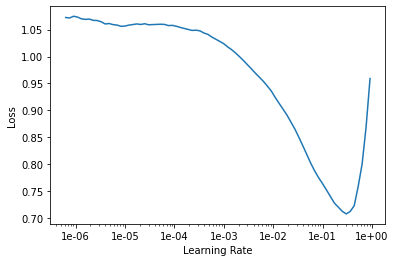

In [241]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.763933,0.429461,0.818767,0.765161,00:15
1,0.443317,0.141705,0.944818,0.876566,00:14
2,0.295215,0.120700,0.949720,0.882323,00:14
3,0.219911,0.118448,0.951120,0.902384,00:14
4,0.176347,0.113395,0.954202,0.901448,00:13


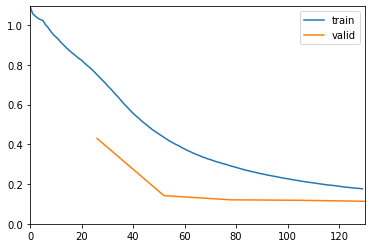

Better model found at epoch 0 with valid_loss value: 0.429460734128952.
Better model found at epoch 1 with valid_loss value: 0.14170469343662262.
Better model found at epoch 2 with valid_loss value: 0.1207003965973854.
Better model found at epoch 3 with valid_loss value: 0.1184481754899025.
Better model found at epoch 4 with valid_loss value: 0.1133950725197792.


In [242]:
learn = learn.to_fp16()
learn.fit_one_cycle(epochs, slice(lr))

In [243]:
learn.save('stage-1')

In [244]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.122018,0.111287,0.954062,0.905756,00:15
1,0.117795,0.107595,0.956163,0.909054,00:15
2,0.113532,0.104328,0.957563,0.915266,00:15
3,0.107051,0.098550,0.958684,0.921004,00:15
4,0.099527,0.098281,0.961064,0.921063,00:15
5,0.094775,0.101333,0.957843,0.913345,00:15
6,0.088638,0.101462,0.959664,0.919537,00:15
7,0.083689,0.098345,0.962185,0.921517,00:14
8,0.078008,0.093433,0.962745,0.928044,00:15
9,0.071893,0.103055,0.958263,0.907290,00:15


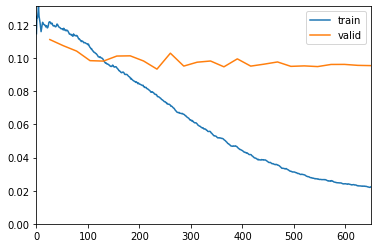

Better model found at epoch 0 with valid_loss value: 0.11128704249858856.
Better model found at epoch 1 with valid_loss value: 0.1075948178768158.
Better model found at epoch 2 with valid_loss value: 0.10432768613100052.
Better model found at epoch 3 with valid_loss value: 0.09855031222105026.
Better model found at epoch 4 with valid_loss value: 0.0982809066772461.
Better model found at epoch 8 with valid_loss value: 0.09343299269676208.


In [245]:
learn.fit_one_cycle(25, slice(1e-5, lr/5))

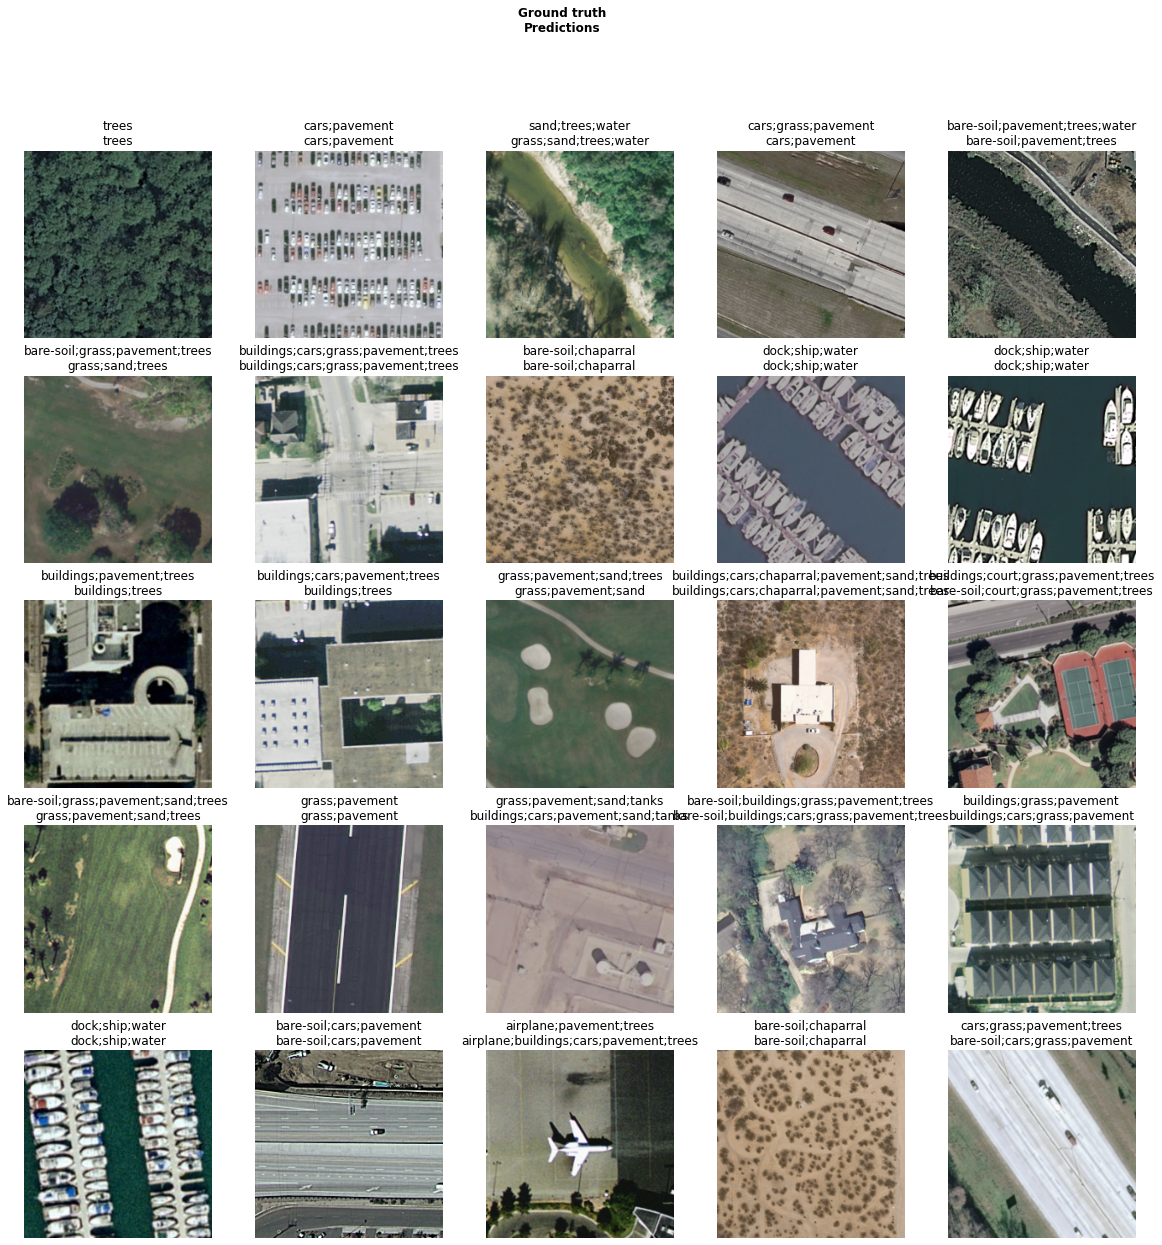

In [246]:
learn.show_results(figsize=(20,20))